In [1]:
import qutip as qt
from qutip import tensor, identity, projection, ket
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras import Model, Sequential, Input
import os 
import itertools
import math
from functools import reduce

In [2]:
"""
Define the creation and annihilation operators
"""
cutoff=5
path = os.getcwd()+'/Bosinic_results/Purely_Dissipative/BEC/cutoff={}'.format(cutoff)
if not os.path.isdir(path):
    os.makedirs(path)
a = qt.destroy(N=cutoff)
adag = qt.create(N=cutoff)
a_tf = tf.constant(a.full(), dtype=tf.complex64)
adag_tf = tf.constant(adag.full(), dtype=tf.complex64)
n = adag*a
n_tf = tf.constant(n, dtype=tf.complex64)
a_ls = [a,adag]
omega= 2 * np.pi * 6.57 #GHz
H = omega * n_tf
H_qt = omega*adag*a
Ham_term_fl = -1j*(qt.spre(H_qt) - qt.spost(H_qt))

2023-01-11 23:34:38.295420: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
"""
Build Basis using projectors
"""
diss_basis = []
diss_basis_adj = []
diss_basis_qt = []
diss_basis_qt_adj = []
for i in range(cutoff):
    for j in range(cutoff):
        op = qt.projection(N=cutoff, n=i,m=j)
        op_adj = qt.projection(N=cutoff, n=i,m=j).dag()
        diss_basis.append(tf.cast(op.full(),dtype=tf.complex64))
        diss_basis_adj.append(tf.cast(op_adj.full(),dtype=tf.complex64))
        diss_basis_qt.append(op)
        diss_basis_qt_adj.append(op_adj)

In [4]:
"""
Build the dissipator which will be cutoffXcutoff and have as many parHam_term_fl
"""
# Use cholesky to ensure a dissipative matrix a_{ij} that is hermitian 
# and positive
def build_A(Vars_in):
    Vars = tf.reshape(Vars_in, shape=(cutoff**2, cutoff**2))
    # separate diagonal elements
    diag_elems = tf.linalg.diag_part(Vars)
    # make a matrix with these on the diag
    diag_matrix = tf.linalg.diag(diag_elems) #+ tf.linalg.diag([0.001] * Var.shape[0])
    # build a lower triangular form with real diagonals
    real_lower_tri = (tf.linalg.LinearOperatorLowerTriangular(Vars).to_dense() - diag_matrix + tf.abs(diag_matrix))
    # get the upper triangular half with zeros on the diagonal, to act as the complex part
    im_lower_tri = (tf.linalg.LinearOperatorLowerTriangular(tf.transpose(Vars)).to_dense() - diag_matrix)
    # build L and L_dag
    L = tf.complex(real=real_lower_tri, imag=im_lower_tri)
    L_dag = tf.linalg.adjoint(L)
    # get A
    A = tf.cast(tf.matmul(L,L_dag), dtype=tf.complex64)
    A_normed = A/tf.cast(tf.reduce_max(tf.math.real(A)), 
                         dtype=tf.complex64)
    return A_normed


def calculate_dissipative_term(A, rho, H):
    """
    A function for building the first standard form of the lindblad Dissipator, from a/a list of 
    parameter matrices A_ls corresponding to the values for each basis element in the Fock Liouville
    basis lists from above
    """
    diss_term = tf.zeros_like(tf.matmul(tf.matmul(tf.cast(tf.constant(qt.projection(N=cutoff, n=0, m=0).full()), dtype=tf.complex64),
                                                  rho),
                                        tf.cast(tf.constant(qt.projection(N=cutoff, n=0, m=0).full()), dtype=tf.complex64)))
    for i in range(cutoff**2):
        for j in range(cutoff**2):
            diss_term+=(A[i,j] * (np.sqrt(cutoff)*omega) * (
                tf.matmul(tf.matmul(diss_basis[i],rho),diss_basis_adj[j]) -
                (1/2)*tf.matmul(tf.matmul(diss_basis_adj[j], diss_basis[i]),rho) -
                (1/2)*tf.matmul(rho, tf.matmul(diss_basis_adj[j], diss_basis[i]))
            ))
    Ham_term = -1j*(tf.matmul(H,rho)-tf.matmul(rho,H))
    return Ham_term+diss_term

def calculate_FL_Liouv_qt(A, H_qt):
    """
    A function for building the first standard form of the lindblad Dissipator, from a/a list of 
    parameter matrices A_ls corresponding to the values for each basis element in the Fock Liouville
    basis lists from above
    """
    A_np = A.numpy()
    diss_term = qt.sprepost(qt.projection(N=cutoff,n=0,m=0), qt.projection(N=cutoff,n=0,m=0))
    for i in range(cutoff**2):
        for j in range(cutoff**2):
            diss_basis_i = diss_basis_qt[i]
            diss_basis_j = diss_basis_qt_adj[j] 
            diss_term+= (A_np[i,j] * (np.sqrt(cutoff)*omega) *(
                qt.sprepost(diss_basis_i, diss_basis_j)
                - (1/2) * (
                    qt.spre((diss_basis_j * diss_basis_i)) +
                    qt.spost((diss_basis_j * diss_basis_i))
                            )
            ))

    return diss_term


In [5]:
def target_GKP(cutoff=35, grid_type="sq", logical_state='zero', 
                   delta=0.3, sum_extent=7, rect_lambda=None):
        """
        Params: 
        grid_type: (str) Either "sq", "rect" or "hex" to define the shape of the grid
                         upon which to build the GKP state.
        delta: (float [0,1]) The width of the Gaussian envelope applied to the ideal GKP 
                            state
        """
        a = qt.destroy(N=cutoff)
        # Assign the alpha and beta params based on the grid type
        if grid_type=="sq":
            alpha = np.sqrt((np.pi/2))
            beta = 1j * np.sqrt((np.pi/2))
        elif grid_type=="hex":
            alpha = np.sqrt((np.pi/np.sqrt(3)))
            beta = np.exp(2 * 1j * (np.pi/3)) * np.sqrt((np.pi/np.sqrt(3)))
        elif grid_type=="rect" and rect_lambda is not None:
            alpha = rect_lambda * np.sqrt((np.pi/2))
            beta = (1j/rect_lambda) * np.sqrt((np.pi/2))
        elif grid_type=="rect" and rect_lambda is None:
            raise TypeError("'rect' requires specification of lambda.")
        else:
            raise TypeError("Incorrect type. Use either 'sq', 'hex', or 'rect'.")
        # define the Gaussian operator to make the state approximate
        env_op = (-1 * (delta**2) * a*a.dag()).expm()
        # Define extent for summation over 
        grid_extent = np.arange(-sum_extent,sum_extent)
        elem_ls = []
        if logical_state=='zero':
            for k in grid_extent:
                for l in grid_extent:
                    coeff = np.exp(-1j * np.pi * k * l)
                    coh_amp = 2 * k * alpha + l * beta
                    elem = coeff * qt.coherent(N=cutoff, alpha=coh_amp)
                    elem_ls.append(elem)
        elif logical_state=='one':
            for k in grid_extent:
                for l in grid_extent:
                    coeff = np.exp(-1j * np.pi * (k * l + (l/2)))
                    coh_amp = (2 * k + 1) * alpha + l * beta
                    elem = coeff * qt.coherent(N=cutoff, alpha=coh_amp)
                    elem_ls.append(elem)
        else:
            raise TypeError("Logical state can only be {0,1}")
        ideal_GKP = sum(elem_ls)
        approx_GKP = env_op * ideal_GKP
        approx_GKP_normed = approx_GKP/approx_GKP.norm()
        return approx_GKP_normed, ideal_GKP, qt.ket2dm(approx_GKP_normed)
    


In [6]:
# _,_,GKP =target_GKP(cutoff=cutoff)
GKP = qt.ket2dm(((qt.fock(dimensions=cutoff, n=4) + qt.fock(dimensions=cutoff, n=0))/np.sqrt(2)))
target = tf.constant(GKP.full(), dtype=tf.complex64)
learningrate = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1., 
                                                              decay_steps=5, 
                                                              decay_rate=0.99
                                                             )

In [7]:
optim_1 = tf.keras.optimizers.Adam(learning_rate=learningrate)
cost_ls = []
steps = 0
Diss_Vars = tf.Variable(np.random.uniform(1,0.999, size =(cutoff**2*cutoff**2)), dtype=tf.float32)
checkpoint_count=0
checkpoint_steps=25
benchmark = 1000000
max_steps = 5000
done=False
while not done:
    # print("Step: {}".format(steps))
    with tf.GradientTape() as tape:
        C = build_A(Diss_Vars)
        out = calculate_dissipative_term(C, target, H)
        dist = tf.reduce_sum(tf.abs(out)**2)
        cost = dist
    cost_ls.append(cost)
    grads = tape.gradient(cost, Diss_Vars)
    optim_1.apply_gradients(zip([grads], [Diss_Vars]));
    steps+=1
    if cost<benchmark:
        best_Diss_Vars = Diss_Vars
        benchmark=cost
    if steps>max_steps:
        done=True
    if steps%checkpoint_steps==0:
        print("Checkpont: {}, Step: {}, Cost: {}, Current Best: {}".format(checkpoint_count, steps, cost, benchmark))
        checkpoint_count+=1
best_path = path+'/Best'
if os.path.isdir(best_path)==False:
    os.makedirs(best_path)
np.savetxt(best_path+'/Diss_Vars', np.reshape(best_Diss_Vars.numpy(),newshape = (cutoff**2,cutoff**2)))
np.savetxt(best_path+'/Cost', np.array(cost_ls))

Checkpont: 0, Step: 25, Cost: 14277.806640625, Current Best: 13638.6904296875
Checkpont: 1, Step: 50, Cost: 9156.0712890625, Current Best: 9156.0712890625
Checkpont: 2, Step: 75, Cost: 6604.66455078125, Current Best: 6604.66455078125
Checkpont: 3, Step: 100, Cost: 4598.8544921875, Current Best: 4598.8544921875
Checkpont: 4, Step: 125, Cost: 3062.60595703125, Current Best: 3062.60595703125
Checkpont: 5, Step: 150, Cost: 2053.56884765625, Current Best: 2053.56884765625
Checkpont: 6, Step: 175, Cost: 1505.2230224609375, Current Best: 1505.2230224609375
Checkpont: 7, Step: 200, Cost: 1171.242431640625, Current Best: 1171.242431640625
Checkpont: 8, Step: 225, Cost: 946.3258056640625, Current Best: 946.3258056640625
Checkpont: 9, Step: 250, Cost: 786.60205078125, Current Best: 786.60205078125
Checkpont: 10, Step: 275, Cost: 667.5514526367188, Current Best: 667.5514526367188
Checkpont: 11, Step: 300, Cost: 575.4779663085938, Current Best: 575.4779663085938
Checkpont: 12, Step: 325, Cost: 502.

KeyboardInterrupt: 

(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot:xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

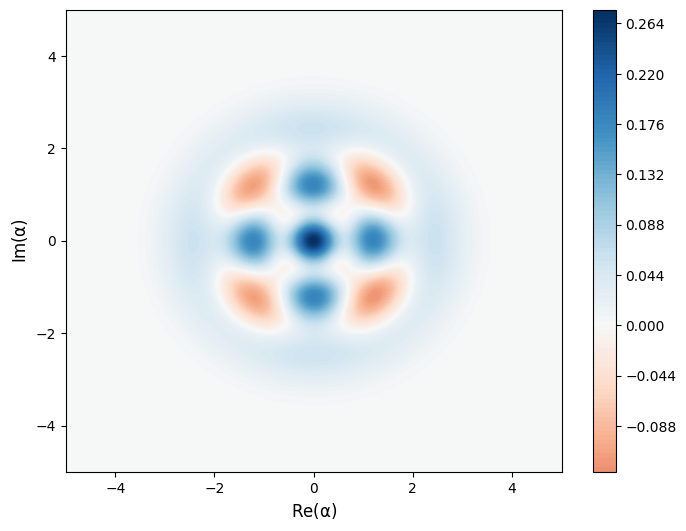

In [8]:
C = build_A(best_Diss_Vars)
Diss= calculate_FL_Liouv_qt(C, H_qt)
Liouv = Diss + Ham_term_fl
rho_ss = qt.steadystate(A=Liouv)
W_ss = qt.distributions.WignerDistribution(rho = rho_ss)
W_ss.visualize()

(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot:xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>)

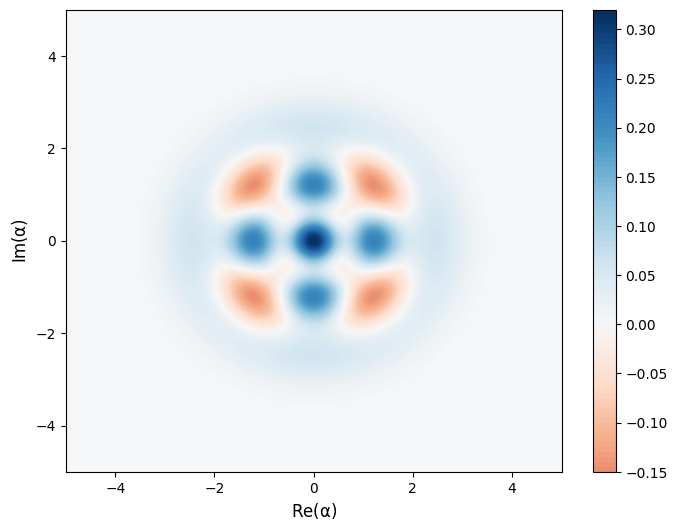

In [9]:
W_targ = qt.distributions.WignerDistribution(rho = GKP)
W_targ.visualize()

In [10]:
qt.fidelity(GKP, rho_ss)

0.9228380764129538

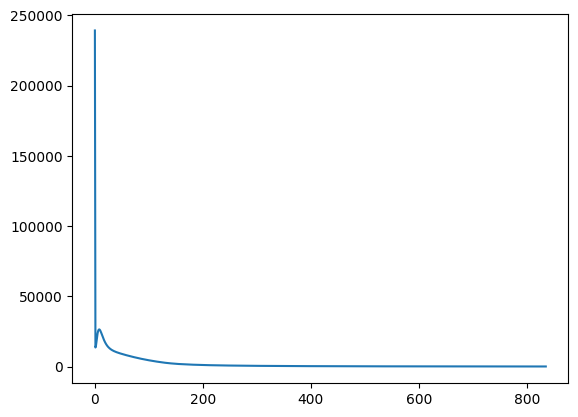

In [11]:
plt.plot(cost_ls)


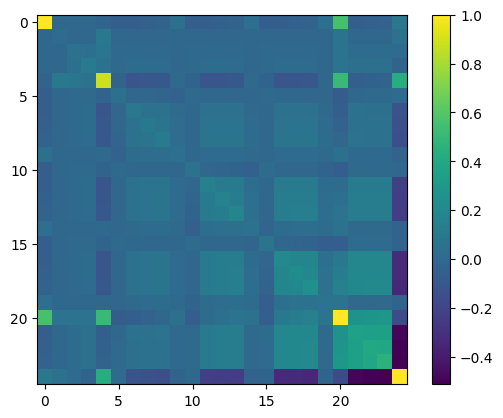

In [12]:
plt.imshow(C.numpy().real)
plt.colorbar()

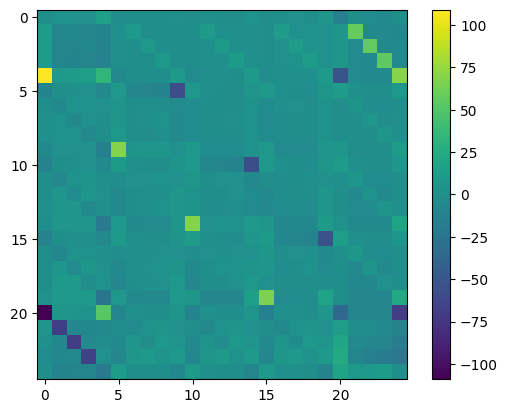

In [13]:
plt.imshow(Diss.full().imag)
plt.colorbar()

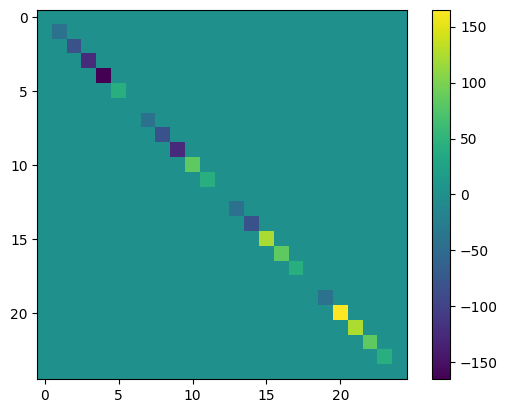

In [14]:
plt.imshow(Ham_term_fl.full().imag)
plt.colorbar()

In [15]:
x = np.arange(5000)
y = 0.1 * (0.999** (x / 1))

In [ ]:
plt.plot(x,y)

In [ ]:
y[4999]

## 